In [30]:
# data processing
import pandas as pd
import geopandas as gpd
import numpy as np
import carto2gpd

# graphics
from matplotlib import pyplot as plt
import hvplot.pandas

# census
import cenpy

# bus ridership data
from sodapy import Socrata

In [31]:
# get the bus ridership data from API
client = Socrata("data.cityofchicago.org", None)
results = client.get("mq3i-nnqe", limit=11593) # length of data shown on their website

bus_ridership_df = pd.DataFrame.from_records(results)

In [32]:
# add geometry
bus_ridership_lat = [row['latitude'] for row in bus_ridership_df['location']]
bus_ridership_lat_df = pd.DataFrame(np.column_stack([bus_ridership_lat]))
bus_ridership_lon = [row['longitude'] for row in bus_ridership_df['location']]
bus_ridership_lon_df = pd.DataFrame(np.column_stack([bus_ridership_lon]))

bus_ridership_df['latitude'] = bus_ridership_lat_df
bus_ridership_df['longitude'] = bus_ridership_lon_df

bus_ridership_gdf = gpd.GeoDataFrame(
    bus_ridership_df, geometry=gpd.points_from_xy(x=bus_ridership_df.longitude, y=bus_ridership_df.latitude)
)

In [33]:
# create a gdf for bus stop data
bus_data = bus_ridership_gdf[['stop_id', 'on_street', 'cross_street', 'routes', 'boardings', 'alightings', 'geometry']]

In [34]:
# set the crs of bus stops to epsg:3857
bus_data.crs = "EPSG:4326"
bus_data = bus_data.to_crs("epsg:3857")

In [35]:
bus_data

,stop_id,on_street,cross_street,routes,boardings,alightings,geometry
0,1,JACKSON,AUSTIN,126,183.4,150.0,POINT (-9770968.653 5142471.022)
1,2,JACKSON,MAYFIELD (EXTENDED),126,5.3,0.2,POINT (-9770658.419 5142582.396)
2,3,JACKSON,MENARD,126,8.3,0.7,POINT (-9770483.920 5142566.019)
3,4,JACKSON,5700 WEST,126,17.9,3.0,POINT (-9770227.903 5142576.026)
4,6,JACKSON,LOTUS,126,74.0,11.2,POINT (-9769559.480 5142499.601)
...,...,...,...,...,...,...,...
11588,17706,100TH STREET,PAXTON,"J14,15",3.6,49.5,POINT (-9748206.961 5118143.676)
11589,17707,43RD STREET,OAKENWALD,43,21.0,69.1,POINT (-9751317.200 5133584.736)
11590,17708,43RD STREET,LAKE PARK,43,24.8,0.9,POINT (-9751488.107 5133602.213)
11591,17709,43RD STREET,BERKELEY,43,14.7,0.9,POINT (-9751642.899 5133599.965)


In [36]:
# make cenpy api connection
acs = cenpy.remote.APIConnection("ACSDT5Y2019")

In [37]:
# get block group gemetry from census data
# set geo server
acs.set_mapservice("tigerWMS_ACS2019")

# Use SQL to return geometries only for Cook County, IL
where_clause = f"STATE = {'17'} AND COUNTY = {'031'}"

# Query for block groups
cook_bg = acs.mapservice.layers[10].query(where=where_clause)

C:\Users\m1861\miniconda3\envs\musa-550-fall-2021\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [38]:
# review the first few rows of block groups in cook county
cook_bg.head()

,MTFCC,OID,GEOID,STATE,COUNTY,TRACT,BLKGRP,BASENAME,NAME,LSADC,FUNCSTAT,AREALAND,AREAWATER,CENTLAT,CENTLON,INTPTLAT,INTPTLON,OBJECTID,geometry
0,G5030,208593711027274,170318037012,17,031,803701,2,2,Block Group 2,BG,S,1046984,0,+42.1199966,-088.0552504,+42.1199966,-088.0552504,25,"POLYGON ((-9803141.453 5178998.109, -9803140.8..."
1,G5030,208593711027495,170318300071,17,031,830007,1,1,Block Group 1,BG,S,1244665,0,+41.4887933,-087.7225617,+41.4887933,-087.7225617,31,"POLYGON ((-9766323.979 5084589.773, -9766307.3..."
2,G5030,208593711029519,170318294023,17,031,829402,3,3,Block Group 3,BG,S,912164,0,+41.4932232,-087.6597212,+41.4932232,-087.6597212,128,"POLYGON ((-9759856.205 5085265.060, -9759855.9..."
3,G5030,208593711030516,170313018023,17,031,301802,3,3,Block Group 3,BG,S,116338,0,+41.8433011,-087.7279502,+41.8433011,-087.7279502,129,"POLYGON ((-9766264.980 5137662.682, -9766246.9..."
4,G5030,208593711030518,170313018022,17,031,301802,2,2,Block Group 2,BG,S,146812,0,+41.8467055,-087.7280227,+41.8467055,-087.7280227,130,"POLYGON ((-9766183.605 5138085.727, -9766183.1..."


In [39]:
# calculate the total area of each block group
cook_bg["TOTALAREA"] = cook_bg.area

In [40]:
# import Chicago city limit
city_boundary_gdf = gpd.read_file("https://data.cityofchicago.org/resource/qqq8-j68g.geojson").to_crs('epsg:3857')

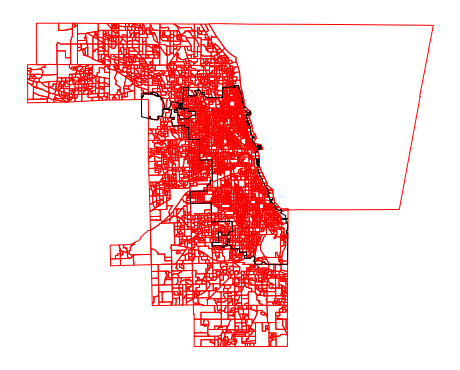

In [41]:
# plot the city boundary geometry over cook block groups geometries
fig, ax = plt.subplots(figsize=(8, 8))
cook_bg.plot(ax=ax, facecolor='none', edgecolor='red')
city_boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

In [42]:
# get blcok groups within Chicaco
joined = gpd.sjoin(cook_bg, city_boundary_gdf, op='intersects', how="inner") 

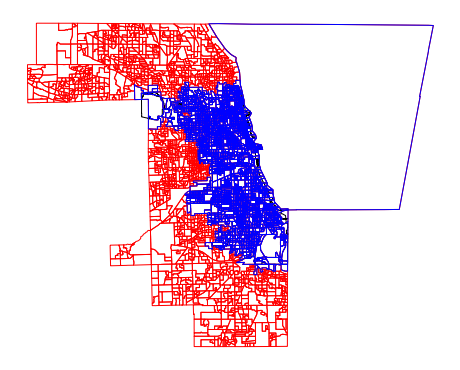

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))
cook_bg.plot(ax=ax, facecolor='none', edgecolor='red')
city_boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
joined.plot(ax=ax, facecolor='none', edgecolor='blue')
ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

In [44]:
# there is a huge block group in the Michigan Lake, find out it's GEOID by sorting the total area
cook_bg.sort_values(by = "TOTALAREA", ascending = False).head(1)['GEOID']

2391    170319900000
Name: GEOID, dtype: object

In [45]:
# remove it from the dataset
joined = joined[joined["GEOID"] != "170319900000"]

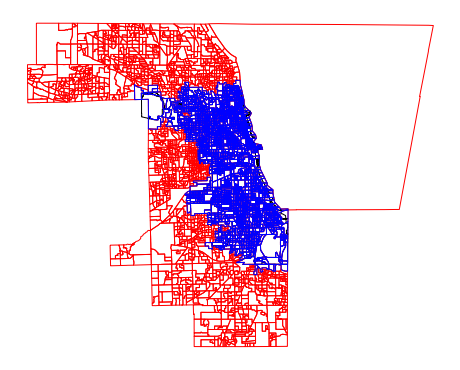

In [46]:
# plot and examine
fig, ax = plt.subplots(figsize=(8, 8))
cook_bg.plot(ax=ax, facecolor='none', edgecolor='red')
city_boundary_gdf.plot(ax=ax, facecolor='none', edgecolor='black')
joined.plot(ax=ax, facecolor='none', edgecolor='blue')
ax.set_axis_off()
ax.set_aspect("equal")
plt.show()

In [47]:
# we only need the geometry and GEOID for the block groups
chicago_bg = joined[['GEOID', 'geometry']]

In [48]:
# review the dataset
chicago_bg

,GEOID,geometry
3,170313018023,"POLYGON ((-9766264.980 5137662.682, -9766246.9..."
4,170313018022,"POLYGON ((-9766183.605 5138085.727, -9766183.1..."
5,170310714002,"POLYGON ((-9755791.151 5149027.292, -9755728.1..."
6,170310714004,"POLYGON ((-9756015.571 5149669.878, -9755930.3..."
7,170310702002,"POLYGON ((-9757027.911 5150298.892, -9756959.0..."
...,...,...
3987,170311710002,"POLYGON ((-9772980.773 5152277.921, -9772958.8..."
3988,170311710003,"POLYGON ((-9773657.484 5152261.308, -9773630.5..."
3989,170311710005,"POLYGON ((-9774219.536 5152794.556, -9774192.0..."
3990,170314606001,"POLYGON ((-9747749.209 5121694.207, -9747736.7..."


In [49]:
# listing socioeconomics variables from 2019 5-year acs 
variables = [
    "NAME",
    "B01003_001E", # total pop
    "B25064_001E", # median rent
    "B19113_001E", # median income
    "B01002_001E", # median age
    "B15003_001E", # educational attainment for the pop 25 and over 
    "B15003_022E", # total bachelor's degree
    "B15003_023E", # master's degree                    
    "B15003_024E", # professional degree
    "B15003_025E", # doctoral
    "B08012_001E", # total commuters
    "B08012_002E", # commute < 5
    "B08012_003E", # 5  < commute < 9
    "B08012_004E", # 10 < commute < 14
    "B08012_005E", # 15 < commute < 19
    "B08012_006E", # 20 < commute < 24
    "B08012_007E", # 25 < commute < 29
    "B08012_008E", # 30 < commute < 34                   
    "B08012_009E", # 35 < commute < 39
    "B08012_010E", # 40 < commute < 44
    "B08012_011E", # 45 < commute < 59
    "B08012_012E", # 60 < commute < 89
    "B08012_013E", # 90 < commute
    "B02001_002E", # white
    "B02001_003E", # african american
    "B01001F_002E", # male
    "B01001F_017E", # female
    "B08006_004E", # carpooled                      
    "B08201_001E", # total household
    "B08201_002E", # household without vehicles
    "B25003_002E", # tenure: owner
    "B06008_001E", # total marriagestatus
    "B06008_002E", # single                     
    "B06008_004E", # divorced
    "B09018_002E", # with children
    "B25027_002E",  # household with mortgage
    "GEO_ID"
]

In [50]:
# query from the cenpy api
cook_data = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": "17", 
                "county": "031", 
                "tract": "*"},
)

In [51]:
# rename the columns for easier references
dict = {"NAME": "NAME",
    "B01003_001E": "total_pop",
    "B25064_001E": "median_rent",
    "B19113_001E": "median_income",
    "B01002_001E": "median_age",
    "B15003_001E": "educational_attainment_pop25" ,
    "B15003_022E": "bachelor_degree",
    "B15003_023E": "master_degree"  ,                  
    "B15003_024E": "professional_degree",
    "B15003_025E": "doctoral_degree",
    "B08012_001E": "total_commuters",
    "B08012_002E": "commute_0-5",
    "B08012_003E": "commute_5-9",
    "B08012_004E": "commute_10-14",
    "B08012_005E": "commute_15-19",
    "B08012_006E": "commute_20-24",
    "B08012_007E": "commute_25-29",
    "B08012_008E": "commute_30-34",                  
    "B08012_009E": "commute_35-39",
    "B08012_010E": "commute_40-44",
    "B08012_011E": "commute_45-59",
    "B08012_012E": "commute_60-89",
    "B08012_013E": "commute_90-inf",
    "B02001_002E": "white",
    "B02001_003E": "african_american",
    "B01001F_002E": "male",
    "B01001F_017E": "female",
    "B08006_004E": "carpooled"  ,                    
    "B08201_001E": "total_household",
    "B08201_002E": "household_without_vehicles",
    "B25003_002E": "tenure_owner",
    "B06008_001E": "total_marriagestatus",
    "B06008_002E": "single",                   
    "B06008_004E": "divorced",
    "B09018_002E": "with_children",
    "B25027_002E": "household_with_mortgage",
    "GEO_ID": "GEO_ID"}

cook_data.rename(columns=dict, inplace=True)

In [52]:
# review the dataset
cook_data

,NAME,total_pop,median_rent,median_income,median_age,educational_attainment_pop25,bachelor_degree,master_degree,professional_degree,doctoral_degree,...,total_marriagestatus,single,divorced,with_children,household_with_mortgage,GEO_ID,state,county,tract,block group
0,"Block Group 1, Census Tract 8089, Cook County,...",1408,1427,223611,41.9,975,314,291,104,164,...,None,None,None,374,None,1500000US170318089001,17,031,808900,1
1,"Block Group 3, Census Tract 8089, Cook County,...",2068,1875,152009,46.1,1419,458,487,139,92,...,None,None,None,588,None,1500000US170318089003,17,031,808900,3
2,"Block Group 1, Census Tract 8098, Cook County,...",1003,1450,140536,33.9,704,360,210,23,59,...,None,None,None,230,None,1500000US170318098001,17,031,809800,1
3,"Block Group 3, Census Tract 8101, Cook County,...",775,1204,140029,37.1,519,172,165,13,37,...,None,None,None,256,None,1500000US170318101003,17,031,810100,3
4,"Block Group 4, Census Tract 8101, Cook County,...",506,1520,119000,40.5,391,157,109,74,0,...,None,None,None,115,None,1500000US170318101004,17,031,810100,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,"Block Group 1, Census Tract 714, Cook County, ...",931,1587,195789,27.7,570,285,75,98,60,...,None,None,None,133,None,1500000US170310714001,17,031,071400,1
3989,"Block Group 1, Census Tract 8001, Cook County,...",942,-666666666,250001,50.9,679,254,165,136,30,...,None,None,None,200,None,1500000US170318001001,17,031,800100,1
3990,"Block Group 1, Census Tract 8013, Cook County,...",876,1146,186375,49.3,616,176,151,65,124,...,None,None,None,178,None,1500000US170318013001,17,031,801300,1
3991,"Block Group 2, Census Tract 8039.01, Cook Coun...",1787,2202,113355,34.6,1320,507,254,0,0,...,None,None,None,359,None,1500000US170318039012,17,031,803901,2


In [53]:
# getting the GEOID for spatial join
cook_data["GEOID"] = [x[9:] for x in cook_data['GEO_ID']]

In [54]:
# review the first few rows of the dataset
cook_data['GEOID']

0       170318089001
1       170318089003
2       170318098001
3       170318101003
4       170318101004
            ...     
3988    170310714001
3989    170318001001
3990    170318013001
3991    170318039012
3992    170318041064
Name: GEOID, Length: 3993, dtype: object

In [55]:
# merge the chicago block group gemoetry with socioeconomic variables by GEOID
chicago_data = chicago_bg.merge(cook_data, on = "GEOID") 

In [56]:
# review the dataset
chicago_data

,GEOID,geometry,NAME,total_pop,median_rent,median_income,median_age,educational_attainment_pop25,bachelor_degree,master_degree,...,total_marriagestatus,single,divorced,with_children,household_with_mortgage,GEO_ID,state,county,tract,block group
0,170313018023,"POLYGON ((-9766264.980 5137662.682, -9766246.9...","Block Group 3, Census Tract 3018.02, Cook Coun...",1560,800,36250,28.7,869,87,8,...,None,None,None,386,None,1500000US170313018023,17,031,301802,3
1,170313018022,"POLYGON ((-9766183.605 5138085.727, -9766183.1...","Block Group 2, Census Tract 3018.02, Cook Coun...",1178,796,29643,25.4,599,25,0,...,None,None,None,334,None,1500000US170313018022,17,031,301802,2
2,170310714002,"POLYGON ((-9755791.151 5149027.292, -9755728.1...","Block Group 2, Census Tract 714, Cook County, ...",2018,1628,159205,38.8,1798,556,496,...,None,None,None,101,None,1500000US170310714002,17,031,071400,2
3,170310714004,"POLYGON ((-9756015.571 5149669.878, -9755930.3...","Block Group 4, Census Tract 714, Cook County, ...",739,1695,238421,35.1,597,192,201,...,None,None,None,117,None,1500000US170310714004,17,031,071400,4
4,170310702002,"POLYGON ((-9757027.911 5150298.892, -9756959.0...","Block Group 2, Census Tract 702, Cook County, ...",1187,1431,181736,30.8,819,315,103,...,None,None,None,214,None,1500000US170310702002,17,031,070200,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,170311710002,"POLYGON ((-9772980.773 5152277.921, -9772958.8...","Block Group 2, Census Tract 1710, Cook County,...",731,-666666666,136382,54.0,590,67,65,...,None,None,None,75,None,1500000US170311710002,17,031,171000,2
2323,170311710003,"POLYGON ((-9773657.484 5152261.308, -9773630.5...","Block Group 3, Census Tract 1710, Cook County,...",1022,-666666666,113295,46.8,718,167,126,...,None,None,None,161,None,1500000US170311710003,17,031,171000,3
2324,170311710005,"POLYGON ((-9774219.536 5152794.556, -9774192.0...","Block Group 5, Census Tract 1710, Cook County,...",1178,769,84766,49.9,885,142,58,...,None,None,None,137,None,1500000US170311710005,17,031,171000,5
2325,170314606001,"POLYGON ((-9747749.209 5121694.207, -9747736.7...","Block Group 1, Census Tract 4606, Cook County,...",1200,840,39837,36.7,819,103,22,...,None,None,None,181,None,1500000US170314606001,17,031,460600,1


In [57]:
chicago_data.columns

Index(['GEOID', 'geometry', 'NAME', 'total_pop', 'median_rent',
       'median_income', 'median_age', 'educational_attainment_pop25',
       'bachelor_degree', 'master_degree', 'professional_degree',
       'doctoral_degree', 'total_commuters', 'commute_0-5', 'commute_5-9',
       'commute_10-14', 'commute_15-19', 'commute_20-24', 'commute_25-29',
       'commute_30-34', 'commute_35-39', 'commute_40-44', 'commute_45-59',
       'commute_60-89', 'commute_90-inf', 'white', 'african_american', 'male',
       'female', 'carpooled', 'total_household', 'household_without_vehicles',
       'tenure_owner', 'total_marriagestatus', 'single', 'divorced',
       'with_children', 'household_with_mortgage', 'GEO_ID', 'state', 'county',
       'tract', 'block group'],
      dtype='object')

In [58]:
# converting strings to numeric input
for variable in chicago_data.columns:
    
    # Convert all variables
    if variable != "NAME" and variable != "GEO_ID" and variable != "geometry" and variable != "GEOID":
        chicago_data[variable] = chicago_data[variable].astype(float)

In [59]:
# spatial join the boarding and alighting from bus stop data
chicago_bg = gpd.sjoin(chicago_bg, bus_data, how = "left")

In [60]:
chicago_bg = chicago_bg[["GEOID", "boardings", "alightings"]]

In [61]:
# converting strings to numeric input
for variable in chicago_bg.columns:
    
    if variable != "GEOID":
    # Convert all variables
        chicago_bg[variable] = chicago_bg[variable].astype(float)

In [62]:
# find the average abordings and alightings in each chicago block group
bus_bg = chicago_bg.groupby("GEOID")[["boardings", "alightings"]].mean()

In [63]:
# review the dataset
bus_bg 

,boardings,alightings
GEOID,,
170310101001,NaN,NaN
170310101002,9.2,2.600000
170310101003,23.5,98.300000
170310102011,NaN,NaN
170310102012,51.0,70.325000
...,...,...
170318439003,17.3,31.650000
170318439004,NaN,NaN
170318439005,23.4,127.700000


In [64]:
# change all NaN value to 0 and round all boardings and alightings to integers
bus_bg = bus_bg.replace(np.nan, 0).round(0)

In [65]:
# review the dataset
bus_bg 

,boardings,alightings
GEOID,,
170310101001,0.0,0.0
170310101002,9.0,3.0
170310101003,24.0,98.0
170310102011,0.0,0.0
170310102012,51.0,70.0
...,...,...
170318439003,17.0,32.0
170318439004,0.0,0.0
170318439005,23.0,128.0


In [66]:
# merge the socioeconomics data with bus stop data
chicago_data = chicago_data.merge(bus_bg, on = "GEOID")

In [67]:
# examine the gdf
chicago_data

,GEOID,geometry,NAME,total_pop,median_rent,median_income,median_age,educational_attainment_pop25,bachelor_degree,master_degree,...,divorced,with_children,household_with_mortgage,GEO_ID,state,county,tract,block group,boardings,alightings
0,170313018023,"POLYGON ((-9766264.980 5137662.682, -9766246.9...","Block Group 3, Census Tract 3018.02, Cook Coun...",1560.0,800.0,36250.0,28.7,869.0,87.0,8.0,...,NaN,386.0,NaN,1500000US170313018023,17.0,31.0,301802.0,3.0,165.0,54.0
1,170313018022,"POLYGON ((-9766183.605 5138085.727, -9766183.1...","Block Group 2, Census Tract 3018.02, Cook Coun...",1178.0,796.0,29643.0,25.4,599.0,25.0,0.0,...,NaN,334.0,NaN,1500000US170313018022,17.0,31.0,301802.0,2.0,10.0,71.0
2,170310714002,"POLYGON ((-9755791.151 5149027.292, -9755728.1...","Block Group 2, Census Tract 714, Cook County, ...",2018.0,1628.0,159205.0,38.8,1798.0,556.0,496.0,...,NaN,101.0,NaN,1500000US170310714002,17.0,31.0,71400.0,2.0,160.0,169.0
3,170310714004,"POLYGON ((-9756015.571 5149669.878, -9755930.3...","Block Group 4, Census Tract 714, Cook County, ...",739.0,1695.0,238421.0,35.1,597.0,192.0,201.0,...,NaN,117.0,NaN,1500000US170310714004,17.0,31.0,71400.0,4.0,255.0,153.0
4,170310702002,"POLYGON ((-9757027.911 5150298.892, -9756959.0...","Block Group 2, Census Tract 702, Cook County, ...",1187.0,1431.0,181736.0,30.8,819.0,315.0,103.0,...,NaN,214.0,NaN,1500000US170310702002,17.0,31.0,70200.0,2.0,92.0,137.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2322,170311710002,"POLYGON ((-9772980.773 5152277.921, -9772958.8...","Block Group 2, Census Tract 1710, Cook County,...",731.0,-666666666.0,136382.0,54.0,590.0,67.0,65.0,...,NaN,75.0,NaN,1500000US170311710002,17.0,31.0,171000.0,2.0,29.0,99.0
2323,170311710003,"POLYGON ((-9773657.484 5152261.308, -9773630.5...","Block Group 3, Census Tract 1710, Cook County,...",1022.0,-666666666.0,113295.0,46.8,718.0,167.0,126.0,...,NaN,161.0,NaN,1500000US170311710003,17.0,31.0,171000.0,3.0,24.0,82.0
2324,170311710005,"POLYGON ((-9774219.536 5152794.556, -9774192.0...","Block Group 5, Census Tract 1710, Cook County,...",1178.0,769.0,84766.0,49.9,885.0,142.0,58.0,...,NaN,137.0,NaN,1500000US170311710005,17.0,31.0,171000.0,5.0,31.0,30.0
2325,170314606001,"POLYGON ((-9747749.209 5121694.207, -9747736.7...","Block Group 1, Census Tract 4606, Cook County,...",1200.0,840.0,39837.0,36.7,819.0,103.0,22.0,...,NaN,181.0,NaN,1500000US170314606001,17.0,31.0,460600.0,1.0,26.0,96.0


In [73]:
type(chicago_data)

C:\Users\m1861\AppData\Local\Temp/ipykernel_14568/654350415.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  chicago_data.to_file("chicago_data.json")


In [74]:
#chicago_data.to_csv('chicago_data_1212.csv', index=False)
chicago_data.to_file("chicago_data.geojson", driver='GeoJSON')